导包

In [82]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import math
import random
import matplotlib.image as mpimg
from PIL import Image
import cv2

# EDA

In [45]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [55]:
# 计算数据集大小
dataset_size = len(data)

# 获取所有图像文件名
image_files = data['ImageName'].values

# 计算类别数量
num_classes = data['cellTypeName'].nunique()

# 获取图像尺寸
image_sizes = []
for image_file in image_files:
    image = Image.open("./Image_classification_data/patch_images/" + image_file)
    image_sizes.append(image.size)

# 计算图像尺寸的均值和标准差
mean_image_size = np.mean(image_sizes, axis=0)
std_image_size = np.std(image_sizes, axis=0)

# 输出结果
print(f"Dataset Size: {dataset_size}")
print(f"Number of Categories: {num_classes}")
print(f"Image Size Mean: {mean_image_size}")
print(f"Image Size Standard Deviation: {std_image_size}")


Dataset Size: 9896
Number of Categories: 4
Image Size Mean: [27. 27.]
Image Size Standard Deviation: [0. 0.]


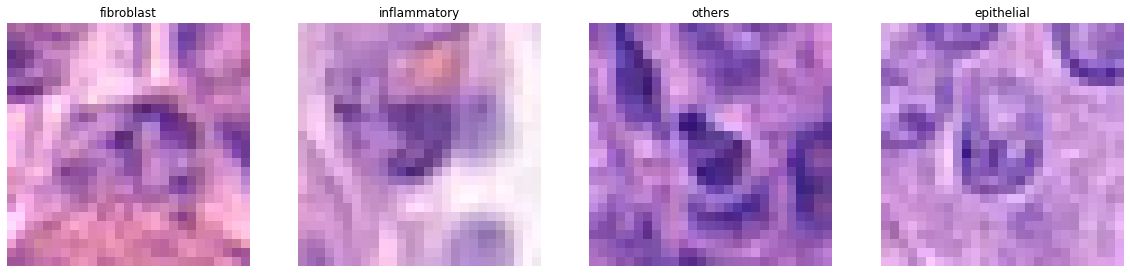

In [88]:
unique_cell_types = data['cellTypeName'].unique()
selected_images = {}

for cell_type in unique_cell_types:
    images_of_cell_type = data[data['cellTypeName'] == cell_type]
    selected_image = images_of_cell_type.sample(n=1).iloc[0]
    selected_images[cell_type] = selected_image['ImageName']

fig, axes = plt.subplots(1, len(unique_cell_types), figsize=(len(unique_cell_types) * 5, 5))

for ax, (cell_type, image_path) in zip(axes, selected_images.items()):
    img = mpimg.imread("./Image_classification_data/patch_images/" + image_path)
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')

plt.show()

In [58]:
def visualize_augmentation(image, generator, num_augmented_images=5):
    # 将 PIL.Image 对象转换为 NumPy 数组，并扩展维度以适应 ImageDataGenerator
    image_array = np.expand_dims(np.array(image), axis=0)

    # 使用 ImageDataGenerator 生成增强图像
    augmented_images = generator.flow(image_array, batch_size=1)

    # 绘制原始图像和增强图像
    fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(15, 15))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for ax, aug_image in zip(axes[1:], augmented_images):
        ax.imshow(aug_image[0].astype(np.uint8))
        ax.set_title("Augmented Image")
        ax.axis("off")

        num_augmented_images -= 1
        if num_augmented_images == 0:
            break

    plt.show()


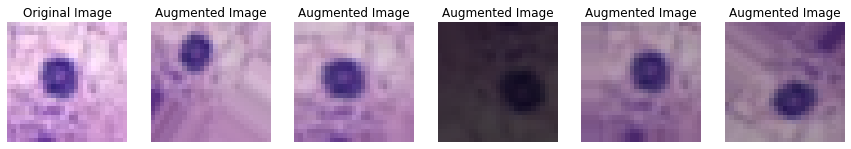

In [97]:
# 随机选择一张图像
selected_image = data.sample(n=1).iloc[0]['ImageName']
image = Image.open("./Image_classification_data/patch_images/" + selected_image)
# 创建 ImageDataGenerator 对象
augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
# 可视化图像增强效果
visualize_augmentation(image, augmentation_generator)

(array([5.87813258, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 4.12186742]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

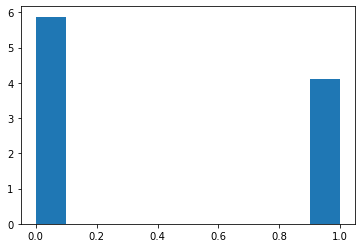

In [98]:
plt.hist(data['isCancerous'], density=True)

(array([0.63594718, 0.        , 0.        , 0.85657505, 0.        ,
        0.        , 0.4668553 , 0.        , 0.        , 1.37395581]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

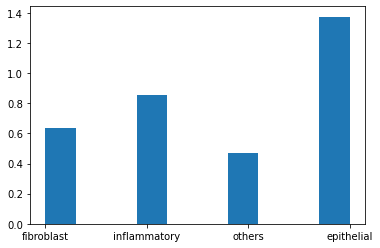

In [99]:
plt.hist(data['cellTypeName'], density=True)

In [73]:
cancer_counts = data.groupby('cellTypeName')['isCancerous'].value_counts().unstack()
cancer_counts.fillna(0, inplace=True)
print(cancer_counts)

isCancerous        0       1
cellTypeName                
epithelial       0.0  4079.0
fibroblast    1888.0     0.0
inflammatory  2543.0     0.0
others        1386.0     0.0


In [79]:
def extract_features(image, extractor):
    # 将图像转换为 OpenCV 格式
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # 提取图像特征
    keypoints, descriptors = extractor.detectAndCompute(image, None)

    # 将提取的特征展平为一维数组
    if descriptors is not None:
        features = np.mean(descriptors, axis=0)
    else:
        features = np.zeros((extractor.descriptorSize(),))

    return features

In [87]:
# 读取数据
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

# 获取所有图像文件名
image_files = data['ImageName'].values

# 创建特征提取器
extractor = cv2.ORB_create()

# 计算每个图像的特征
features = []
for image_file in image_files:
    image = Image.open("./Image_classification_data/patch_images/" + image_file)
    feature = extract_features(image, extractor)
    features.append(feature)

# 将特征转换为 NumPy 数组
features = np.array(features)

# 计算特征之间的余弦相似度
similarities = cosine_similarity(features)

# 设置相似度阈值
similarity_threshold = 0.9

# 找到高于阈值的图像对
similar_pairs = np.where(similarities > similarity_threshold)
similar_pairs = [(i, j) for i, j in zip(similar_pairs[0], similar_pairs[1]) if i != j]

# 输出相似图像对
for i, j in similar_pairs:
    print(f"Similar Image Pair: ({image_files[i]}, {image_files[j]})，相似度: {similarities[i, j]:.2f}")

获取主数据集
test_data 为不可见数据集

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
ia.seed(seed_value)

data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

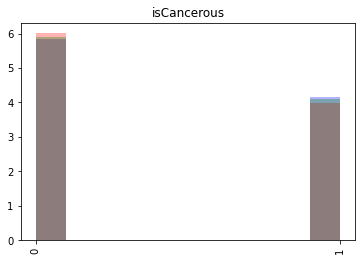

In [3]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['isCancerous'], alpha=0.3, color='g', label='Val',  density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2'), Text(3, 0, '3')])

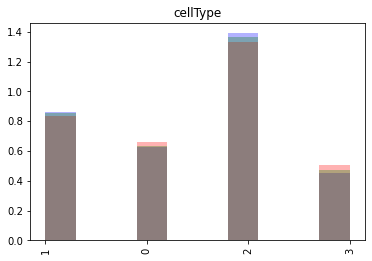

In [4]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [5]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [6]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

In [7]:
batch_size = 32
train_datagen = CustomImageDataGenerator(
    num_augmentations=3,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [8]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [9]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiCategoryF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_category=4, average='macro', name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_category
        self.average = average
        self.confusion_matrix = self.add_weight(name="confusion_matrix", shape=(num_classes, num_classes), initializer="zeros", dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        self.confusion_matrix.assign_add(current_confusion_matrix)


    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp

        precision_per_class = tp / (tp + fp)
        recall_per_class = tp / (tp + fn)

        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")

        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes, "average": self.average})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [10]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01
baseline_binary = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Pro


In [11]:
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
baseline_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                              tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'),
                              F1Score()])

baseline_categorical.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                             metrics=['accuracy',
                                      tf.keras.metrics.Precision(name='precision'),
                                      tf.keras.metrics.Recall(name='recall'),
                                      MultiCategoryF1Score(num_category=4)])

In [13]:
epochs = 100
history_baseline_binary = baseline_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
)

Epoch 1/100


2023-05-08 12:34:00.363647: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


197/197 [==============================] - 5s 24ms/step - loss: 1.1347 - accuracy: 0.7189 - precision: 0.6511 - recall: 0.7033 - f1_score: 0.6762 - val_loss: 0.4566 - val_accuracy: 0.7889 - val_precision: 0.6757 - val_recall: 0.9315 - val_f1_score: 0.7832
Epoch 2/100
197/197 [==============================] - 4s 22ms/step - loss: 0.9054 - accuracy: 0.7967 - precision: 0.7315 - recall: 0.8087 - f1_score: 0.7681 - val_loss: 0.4633 - val_accuracy: 0.7793 - val_precision: 0.6585 - val_recall: 0.9579 - val_f1_score: 0.7805
Epoch 3/100
197/197 [==============================] - 4s 22ms/step - loss: 0.8610 - accuracy: 0.8090 - precision: 0.7405 - recall: 0.8334 - f1_score: 0.7842 - val_loss: 0.3311 - val_accuracy: 0.8603 - val_precision: 0.8501 - val_recall: 0.8012 - val_f1_score: 0.8249
Epoch 4/100
197/197 [==============================] - 4s 21ms/step - loss: 0.8400 - accuracy: 0.8156 - precision: 0.7452 - recall: 0.8464 - f1_score: 0.7926 - val_loss: 0.3519 - val_accuracy: 0.8514 - val_pr

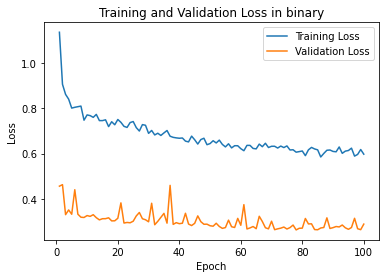

In [14]:
train_loss = history_baseline_binary.history['loss']
val_loss = history_baseline_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

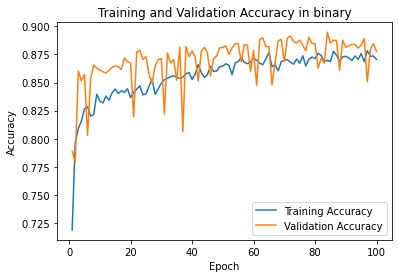

In [15]:
train_accuracy = history_baseline_binary.history['accuracy']
val_accuracy = history_baseline_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [16]:
baseline_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 1s 11ms/step - loss: 0.2834 - accuracy: 0.8899 - precision: 0.8259 - recall: 0.9178 - f1_score: 0.8695


[0.283389687538147,
 0.8898990154266357,
 0.8259385824203491,
 0.9178255200386047,
 0.869460940361023]

In [17]:
epochs = 100
history_baseline_categorical = baseline_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
)

Epoch 1/100
197/197 [==============================] - 5s 25ms/step - loss: 5.3362 - accuracy: 0.4138 - precision: 0.6688 - recall: 0.1006 - f1_score: 0.3726 - val_loss: 1.0084 - val_accuracy: 0.6441 - val_precision: 0.8477 - val_recall: 0.2449 - val_f1_score: nan
Epoch 2/100
197/197 [==============================] - 5s 24ms/step - loss: 4.7167 - accuracy: 0.5389 - precision: 0.7569 - recall: 0.2343 - f1_score: 0.4630 - val_loss: 0.9901 - val_accuracy: 0.5867 - val_precision: 0.7925 - val_recall: 0.3093 - val_f1_score: 0.5266
Epoch 3/100
197/197 [==============================] - 5s 24ms/step - loss: 4.5537 - accuracy: 0.5652 - precision: 0.7592 - recall: 0.3033 - f1_score: 0.4879 - val_loss: 1.2619 - val_accuracy: 0.5338 - val_precision: 0.8271 - val_recall: 0.1983 - val_f1_score: 0.5441
Epoch 4/100
197/197 [==============================] - 5s 24ms/step - loss: 4.4118 - accuracy: 0.5895 - precision: 0.7450 - recall: 0.3340 - f1_score: 0.5129 - val_loss: 0.8725 - val_accuracy: 0.6709

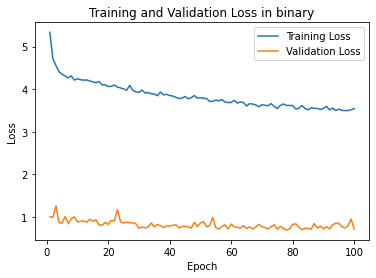

In [18]:
train_loss = history_baseline_categorical.history['loss']
val_loss = history_baseline_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

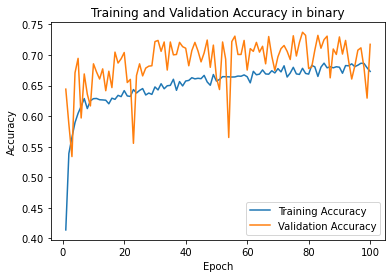

In [19]:
train_accuracy = history_baseline_categorical.history['accuracy']
val_accuracy = history_baseline_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [20]:
baseline_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 1s 14ms/step - loss: 0.7595 - accuracy: 0.6985 - precision: 0.7668 - recall: 0.6177 - f1_score: 0.6535


[0.7595498561859131,
 0.6984848380088806,
 0.766771137714386,
 0.6176767945289612,
 0.653546154499054]

两层卷积一层池化，32，64。两层512感知器。

In [21]:
model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                      

In [22]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [23]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score()])

model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   MultiCategoryF1Score()])

In [24]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

In [25]:
epochs = 100
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 10s 46ms/step - loss: 14.5960 - accuracy: 0.8089 - precision: 0.7361 - recall: 0.8447 - f1_score: 0.7867 - val_loss: 14.2249 - val_accuracy: 0.4094 - val_precision: 0.4094 - val_recall: 1.0000 - val_f1_score: 0.5810 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 8s 43ms/step - loss: 13.3289 - accuracy: 0.8365 - precision: 0.7728 - recall: 0.8605 - f1_score: 0.8143 - val_loss: 12.4138 - val_accuracy: 0.8552 - val_precision: 0.8339 - val_recall: 0.8066 - val_f1_score: 0.8200 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 8s 42ms/step - loss: 12.2456 - accuracy: 0.8476 - precision: 0.7932 - recall: 0.8584 - f1_score: 0.8246 - val_loss: 11.4201 - val_accuracy: 0.8514 - val_precision: 0.7515 - val_recall: 0.9500 - val_f1_score: 0.8392 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 9s 43ms/step - loss: 11.2855 - accuracy: 0.8575 - precision: 0.8055 - recall: 0.867

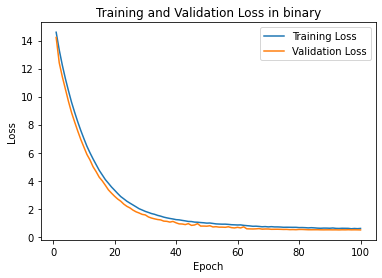

In [26]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

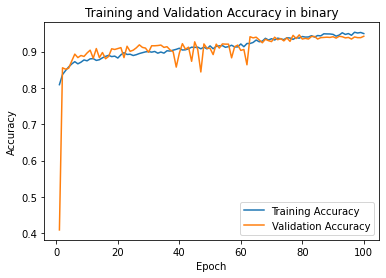

In [27]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

评估不可见数据集的表现

In [28]:
model_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 2s 27ms/step - loss: 0.4998 - accuracy: 0.9298 - precision: 0.9055 - recall: 0.9204 - f1_score: 0.9129


[0.49983057379722595,
 0.9297980070114136,
 0.9054726362228394,
 0.9203540086746216,
 0.9128525853157043]

# 训练多分类

In [29]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 11s 50ms/step - loss: 19.5593 - accuracy: 0.5322 - precision: 0.5731 - recall: 0.4694 - f1_score: 0.4913 - val_loss: 16.1409 - val_accuracy: 0.1907 - val_precision: 0.1907 - val_recall: 0.1907 - val_f1_score: nan - lr: 2.0000e-04
Epoch 2/100
197/197 [==============================] - 9s 46ms/step - loss: 18.1659 - accuracy: 0.5995 - precision: 0.6513 - recall: 0.5292 - f1_score: 0.5520 - val_loss: 15.0457 - val_accuracy: 0.3756 - val_precision: 0.3888 - val_recall: 0.3355 - val_f1_score: 0.4135 - lr: 2.0000e-04
Epoch 3/100
197/197 [==============================] - 9s 46ms/step - loss: 17.3264 - accuracy: 0.6130 - precision: 0.6726 - recall: 0.5492 - f1_score: 0.5659 - val_loss: 14.0718 - val_accuracy: 0.5906 - val_precision: 0.6242 - val_recall: 0.5529 - val_f1_score: 0.4998 - lr: 2.0000e-04
Epoch 4/100
197/197 [==============================] - 9s 45ms/step - loss: 16.7413 - accuracy: 0.6324 - precision: 0.6941 - recall: 0.5616 -

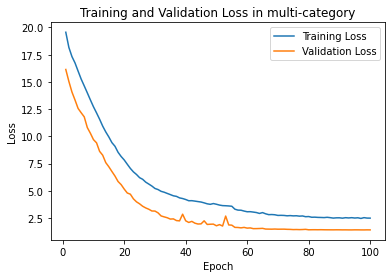

In [30]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

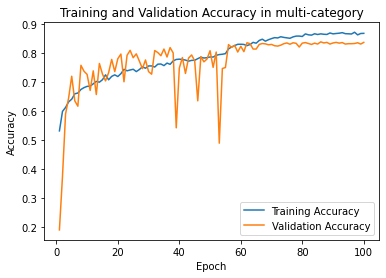

In [31]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [32]:
model_categorical.evaluate(test_cellType_generator)
# loss: 1.4202 - accuracy: 0.8354 - precision: 0.8550 - recall: 0.8131 - f1_score: 0.8098

62/62 [==============================] - 2s 30ms/step - loss: 1.4277 - accuracy: 0.8313 - precision: 0.8514 - recall: 0.8162 - f1_score: 0.8075


[1.427724838256836,
 0.8313131332397461,
 0.8514225482940674,
 0.8161616325378418,
 0.8075346350669861]

In [33]:
model_categorical.save_weights('saved_model/model_categorical_weights')

# DI/HD 使用data_labels_extraData对多分类的模型进行增强

In [34]:
model_categorical.load_weights('saved_model/model_categorical_weights')

In [36]:
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)

In [37]:
binary_samples_isCancerous = data_extra['isCancerous'].value_counts()
total_samples = np.sum(binary_samples_isCancerous)
binary_weights_isCancerous = total_samples / binary_samples_isCancerous
binary_weight_dict_isCancerous = {int(k): v for k, v in binary_weights_isCancerous.to_dict().items()}

In [38]:
# 图片RandAugment增强
class RandAugmentGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rand_aug = iaa.RandAugment(n=n, m=m)

    def apply_transform(self, x, transform_parameters):
        x = tf.cast(x, tf.uint8)
        x_aug = self.rand_aug(image=x.numpy())
        x_aug = tf.cast(x_aug, tf.float64)
        return super().apply_transform(x_aug, transform_parameters)

重新生成新的train_generator

In [39]:
batch_size = 32
train_datagen = CustomImageDataGenerator(
    num_augmentations=3,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

unlabeled_generator_weak = unlabeled_datagen_weak.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')


unlabeled_datagen_strong = RandAugmentGenerator(n=3, m=5, rescale=1./255, fill_mode='nearest')

unlabeled_generator_strong = unlabeled_datagen_strong.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest'
)

test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 4 classes.


## FixMatch 实现

In [40]:
def apply_fixmatch(x, y_true, x_unlabeled, cancer_mask, model, optimizer, training=True, class_weight_dict=None, cancer_weight_dict=None, consistency_weight=1, category_2_weight=1, confidence_threshold=0.95):
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x)
        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            class_weight_tensor = tf.constant([class_weight_dict[0], class_weight_dict[1], class_weight_dict[2], class_weight_dict[3]])
            sample_weights = tf.gather(class_weight_tensor, tf.argmax(y_true, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled))
        final_loss = supervised_loss

        # 计算模型在原始无标签数据和增强无标签数据上的输出
        if x_unlabeled is not None:
            # 对无标签数据进行数据增强
            y_pred_unlabeled_weak = model(x_unlabeled[0])
            y_pred_unlabeled_strong = model(x_unlabeled[1])
            # 计算伪标签
            pseudo_labels = tf.argmax(y_pred_unlabeled_weak, axis=-1)
            # 计算最大概率
            max_probs = tf.reduce_max(y_pred_unlabeled_weak, axis=-1)
            # Confidence-based masking 基于置信度的掩码
            mask = max_probs > confidence_threshold
            # 定义癌症样本和非癌症样本的掩码
            cancer_mask = (cancer_mask[:, 1] == 1)
            non_cancer_mask = tf.math.logical_not(cancer_mask)
            # 计算与预测为2相关的样本的掩码
            pred_2_mask = tf.equal(pseudo_labels, 2)
            not_pred_2_mask = tf.math.logical_not(pred_2_mask)
            # 计算一致性损失的掩码
            # 预测为2但实际不为2
            loss_mask_1 = tf.math.logical_and(pred_2_mask, non_cancer_mask)
            # 预测不为2但实际为2
            loss_mask_2 = tf.math.logical_and(not_pred_2_mask, cancer_mask)
            category_2_loss_mask = tf.math.logical_or(loss_mask_1, loss_mask_2)
            remaining_mask = tf.math.logical_and(mask, tf.math.logical_not(category_2_loss_mask))
            # 计算一致性损失
            pseudo_labels_one_hot = tf.one_hot(pseudo_labels, depth=tf.shape(y_pred_unlabeled_weak)[-1])
            per_example_loss = tf.keras.losses.categorical_crossentropy(pseudo_labels_one_hot, y_pred_unlabeled_strong)
            consistency_loss = tf.reduce_sum(per_example_loss * tf.cast(remaining_mask, per_example_loss.dtype)) / tf.reduce_sum(tf.cast(remaining_mask, tf.float32) + tf.keras.backend.epsilon())
            # 计算 category_2_loss
            binary_labels = tf.cast(cancer_mask, dtype=tf.float32)
            category_2_per_example_loss = tf.keras.losses.binary_crossentropy(binary_labels, y_pred_unlabeled_weak[:, 2])
            if cancer_weight_dict is not None:
                weights = tf.where(cancer_mask, cancer_weight_dict[0], cancer_weight_dict[1])
                category_2_per_example_loss *= weights
            category_2_loss = tf.reduce_sum(category_2_per_example_loss * tf.cast(category_2_loss_mask, category_2_per_example_loss.dtype)) / tf.reduce_sum(tf.cast(category_2_loss_mask, tf.float32) + tf.keras.backend.epsilon())

            final_loss = final_loss + consistency_weight * consistency_loss + category_2_weight * category_2_loss

        # 计算准确度
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_true, y_pred_labeled)

        if training:
            # 反向传播和优化
            grads = tape.gradient(final_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))

    return {"loss": final_loss,
            "supervised_loss": supervised_loss,
            "consistency_loss" :consistency_loss if x_unlabeled is not None else None,
            "category_2_loss": category_2_loss if x_unlabeled is not None else None,
            "accuracy": accuracy.result()}

In [41]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=1e-7)
epochs = 2
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = adam.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_category_2_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled_weak, y_binary), (x_unlabeled_strong, _) in zip(train_generator, unlabeled_generator_weak, unlabeled_generator_strong):
            progress_bar.update(1)
            result = apply_fixmatch(x_batch, y_batch, (x_unlabeled_weak, x_unlabeled_strong),
                                    y_binary, model_categorical, adam)
            total_loss += result["loss"]
            total_supervised_loss += result["supervised_loss"]
            total_consistency_loss += result["consistency_loss"]
            total_category_2_loss += result["category_2_loss"]
            total_accuracy += result["accuracy"]
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_category_2_loss = total_category_2_loss / steps
        avg_accuracy = total_accuracy / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, category_2_loss: {avg_category_2_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_f1_score = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        result = apply_fixmatch(x_batch, y_batch, None, None, model_categorical, adam, False)
        total_loss += result["loss"]
        total_accuracy += result["accuracy"]
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps

    history["val_loss"].append(avg_loss)
    history["val_accuracy"].append(avg_accuracy.numpy())

    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}， lr: {current_learning_rate:.2e}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = avg_loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1
    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        adam.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/2


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:31<00:00,  6.34it/s]

 - loss: 11.0651, supervised_loss: 0.2985, consistency_loss: 10.1800, category_2_loss: 0.5866, accuracy: 0.8967


Validation set： - loss: 0.4501, accuracy: 0.8332， lr: 1.00e-07
Epoch 2/2


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:31<00:00,  6.28it/s]


 - loss: 10.1557, supervised_loss: 0.3000, consistency_loss: 9.2416, category_2_loss: 0.6141, accuracy: 0.8991
Validation set： - loss: 0.4548, accuracy: 0.8377， lr: 1.00e-07


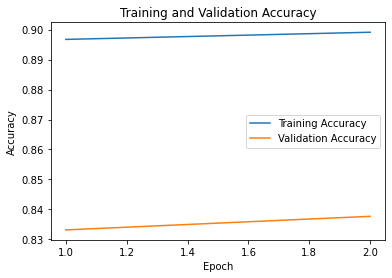

In [42]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

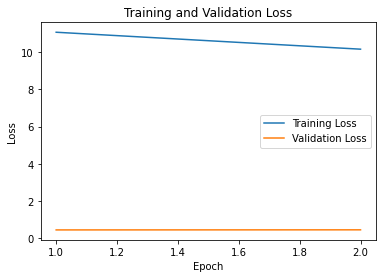

In [43]:
train_loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [44]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 2s 30ms/step - loss: 1.4202 - accuracy: 0.8354 - precision: 0.8550 - recall: 0.8131 - f1_score: 0.8098


[1.4202253818511963,
 0.8353535532951355,
 0.8550186157226562,
 0.8131313323974609,
 0.8098093867301941]